# Analysis of NYC Taxi Cab Data
## Import libraries and connect to database

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import seaborn as sns

# set working directory up a level from this file
os.chdir('..')

# Connect to database:
con = sqlite3.connect("NYC-Taxi.db")

## Extract observations and clean data

The analysis will focus on a sample of a specified number of observations of green and yellow cab data. Data from each of these sources will be stacked together, features created, and then finally a train and test set created.

In [2]:
# need to set seed by randomly sampling indices in python then pass to sql

# specify number of rows with pull variable 
pull = "5000000"
# Store sample of green and yellow cab data into dataframes:
df1 = pd.read_sql(f"SELECT * FROM green_cabs ORDER BY random() LIMIT" + " " +  pull, con=con)
df2 = pd.read_sql(f"SELECT * from yellow_cabs ORDER BY random() LIMIT"+ " " + pull, con=con)

# Add labels for green and yellow cabs and rename pickup/dropoff datetime columns:
df1 = df1.rename(columns={"lpep_pickup_datetime": "pickup_datetime", "lpep_dropoff_datetime":"dropoff_datetime"})
df2 = df2.rename(columns={"tpep_pickup_datetime": "pickup_datetime", "tpep_dropoff_datetime":"dropoff_datetime"})
df1['cab'] = "green"
df2['cab'] = "yellow"

In [3]:
# retain only columns that are in both datasets
cols_to_keep = df1.columns.intersection(df2.columns)
df1 = df1[cols_to_keep]
df2 = df2[cols_to_keep]
del cols_to_keep

# Combine into one data frame:
df = pd.concat([df1, df2], sort=False)
del df1
del df2

# Change format to datetime where necessary:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], unit = "s")
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], unit = "s")

df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge,Source_file,cab
0,1.0,2019-07-02 09:17:55,2019-07-02 09:38:40,N,1.0,41,213,1.0,6.40,21.5,0.0,0.5,0.00,0.00,0.3,22.30,1.0,0.00,green_tripdata_2019-07.csv,green
1,2.0,2019-01-16 10:49:38,2019-01-16 10:56:21,N,1.0,7,223,1.0,0.94,6.5,0.0,0.5,0.00,0.00,0.3,7.30,2.0,NaN,green_tripdata_2019-01.csv,green
2,2.0,2019-03-29 17:26:43,2019-03-29 17:45:21,N,1.0,82,138,1.0,4.81,17.0,1.0,0.5,0.18,0.00,0.3,18.98,1.0,0.00,green_tripdata_2019-03.csv,green
3,2.0,2019-04-22 12:31:27,2019-04-23 11:37:46,N,1.0,95,137,1.0,9.18,34.0,0.0,0.5,6.55,6.12,0.3,50.22,1.0,2.75,green_tripdata_2019-04.csv,green
4,1.0,2019-01-12 14:28:32,2019-01-12 14:50:04,N,1.0,75,170,1.0,3.60,16.5,0.0,0.5,3.46,0.00,0.3,20.76,1.0,NaN,green_tripdata_2019-01.csv,green


In [4]:
df.shape

(10000000, 20)

In [5]:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
count,9.643108e+06,9.643108e+06,1.000000e+07,1.000000e+07,9.643108e+06,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,9.999998e+06,1.000000e+07,9.643108e+06,8.918064e+06
mean,1.740063e+00,1.122039e+00,1.358072e+02,1.452878e+02,1.441119e+00,3.151520e+00,1.391136e+01,8.120807e-01,4.886036e-01,1.588735e+00,3.175112e-01,2.838196e-01,1.821648e+01,1.362059e+00,1.344533e+00
std,4.497706e-01,8.346182e-01,7.416445e+01,7.517301e+01,1.107790e+00,2.681893e+01,1.346558e+02,1.101320e+00,8.520801e-02,2.524013e+00,1.534482e+00,7.098499e-02,1.348643e+02,5.050250e-01,1.269019e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-2.032908e+04,-8.900000e+02,-4.500000e+00,-5.000000e-01,-9.050000e+01,-3.074000e+01,-3.000000e-01,-8.903000e+02,1.000000e+00,-2.750000e+00
25%,1.000000e+00,1.000000e+00,7.400000e+01,7.500000e+01,1.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,9.800000e+00,1.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.370000e+02,1.450000e+02,1.000000e+00,1.780000e+00,1.000000e+01,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.380000e+01,1.000000e+00,2.500000e+00
75%,2.000000e+00,1.000000e+00,1.960000e+02,2.260000e+02,1.000000e+00,3.500000e+00,1.600000e+01,1.000000e+00,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,2.080000e+01,2.000000e+00,2.500000e+00
max,4.000000e+00,9.900000e+01,2.650000e+02,2.650000e+02,9.000000e+00,7.784376e+04,3.958399e+05,8.756000e+01,6.000000e+01,6.000000e+02,6.686300e+02,1.000000e+00,3.958412e+05,5.000000e+00,2.750000e+00


### Remove outliers

In [6]:
df.quantile(q=np.array(range(0,11))*0.1)

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0.0,1.0,1.0,1.0,1.0,0.0,-20329.08,-890.00,-4.50,-0.5,-90.50,-30.74,-0.3,-890.30,1.0,-2.75
0.1,1.0,1.0,41.0,42.0,1.0,0.61,5.00,0.00,0.5,0.00,0.00,0.3,7.30,1.0,0.00
0.2,1.0,1.0,66.0,69.0,1.0,0.90,6.00,0.00,0.5,0.00,0.00,0.3,9.30,1.0,0.00
0.3,2.0,1.0,79.0,90.0,1.0,1.13,7.00,0.00,0.5,0.00,0.00,0.3,10.56,1.0,0.00
0.4,2.0,1.0,100.0,129.0,1.0,1.41,8.50,0.00,0.5,0.00,0.00,0.3,12.25,1.0,0.00
0.5,2.0,1.0,137.0,145.0,1.0,1.78,10.00,0.50,0.5,1.00,0.00,0.3,13.80,1.0,2.50
0.6,2.0,1.0,161.0,164.0,1.0,2.25,11.50,0.50,0.5,1.62,0.00,0.3,15.95,1.0,2.50
0.7,2.0,1.0,170.0,196.0,1.0,2.97,14.50,1.00,0.5,2.06,0.00,0.3,18.81,2.0,2.50
0.8,2.0,1.0,230.0,233.0,2.0,4.26,19.00,1.00,0.5,2.76,0.00,0.3,23.76,2.0,2.50
0.9,2.0,1.0,239.0,239.0,2.0,7.44,28.00,2.75,0.5,3.99,0.00,0.3,34.05,2.0,2.50


In [7]:
df.shape

(10000000, 20)

Based on the above quantiles, the following filters should be applied:
- trip_distance > 0
- passenget_count > 0
- fare_amount > 0
- extra >= 0
- mta_tax >= 0
- tip_amount >= 0
- tolls_amount >= 0
- improvement_surcharge >= 0
- total_amount > 0
- congestion_surcharge >= 0

The upper limits should also be capped at the 99.9th percentile for:
- trip_distance
- fare_amount
- trip_time

Additionally, we only want to look at credit transactions because cash transactions are less likely to have a tip registered:
- payment_type == 1

In [8]:
indices = (df['trip_distance'] > 0) &\
    (df['passenger_count'] > 0) &\
    (df['fare_amount'] > 0) &\
    (df['extra'] >= 0) &\
    (df['mta_tax'] >= 0) &\
    (df['tip_amount'] >= 0) &\
    (df['tolls_amount'] >= 0) &\
    (df['improvement_surcharge'] >= 0) &\
    (df['total_amount'] > 0) &\
    (df['congestion_surcharge'] >= 0) &\
    (df['payment_type'] == 1) &\
    (df['trip_distance'] <= df['trip_distance'].quantile(.999)) &\
    (df['fare_amount'] <= df['fare_amount'].quantile(.999))

df_cleaned = df[indices]
del indices

df_cleaned.shape

(5608550, 20)

### Check for NAs

In [9]:
df_cleaned.isna().sum()

VendorID                 0
pickup_datetime          0
dropoff_datetime         0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
congestion_surcharge     0
Source_file              0
cab                      0
dtype: int64

In [10]:
df = df_cleaned
del df_cleaned

## Feature engineering

### Add in borough information

In [11]:
# Store Pickup location borough names and merge to main data frame:
df_location = pd.read_csv("Data/taxi_zones.csv")
df_location['DOLocationID'] = df_location['LocationID']
df_location = df_location.rename(columns = {'LocationID':'PULocationID'})

# Add borough and Zone name:
df = df.merge(df_location[['PULocationID', 'Borough', 'Zone']], on = "PULocationID", how = 'left')

### Add weather information

In [12]:
# Store Weather informaiton and merge to main data frame

df_weather = pd.read_csv("Data/CP.weather.df.csv")

# convert Date to datetime
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather = df_weather.rename(columns={"Date":"date"})

df['date'] = pd.to_datetime(df['pickup_datetime'].dt.date)

# merge with pickup date
df = df.merge(df_weather, how= 'left')


In [13]:
# Summary stats and structure of data:
df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,Borough,Zone,date,Precipitation,Snow.depth,Snowfall,Max.temp,Min.temp,Avg.wind.speed,Gust.speed
0,1.0,2019-07-02 09:17:55,2019-07-02 09:38:40,N,1.0,41,213,1.0,6.40,21.5,...,Manhattan,Central Harlem,2019-07-02,0.02,0.0,0.0,85.0,71.0,2.5,8.9
1,2.0,2019-03-29 17:26:43,2019-03-29 17:45:21,N,1.0,82,138,1.0,4.81,17.0,...,Queens,Elmhurst,2019-03-29,0.00,0.0,0.0,59.0,49.0,2.0,10.1
2,2.0,2019-04-22 12:31:27,2019-04-23 11:37:46,N,1.0,95,137,1.0,9.18,34.0,...,Queens,Forest Hills,2019-04-22,0.24,0.0,0.0,64.0,52.0,4.5,12.1
3,2.0,2019-03-05 11:49:03,2019-03-05 12:01:08,N,1.0,97,52,1.0,1.28,9.0,...,Brooklyn,Fort Greene,2019-03-05,0.00,2.0,0.0,32.0,20.0,NaN,NaN
4,2.0,2019-07-05 17:03:23,2019-07-05 17:08:04,N,1.0,152,41,1.0,0.97,5.5,...,Manhattan,Manhattanville,2019-07-05,0.00,0.0,0.0,86.0,72.0,2.9,8.9


### Add the following variables

- trip time
- average speed
- day of week
- month
- hour
- holiday dummy code
- tip indicator (1 or 0)

In [14]:
# Include trip time:
df['trip_time'] = (df['dropoff_datetime'] - df['pickup_datetime']).astype('timedelta64[m]')
# filter out impossible trip times
df = df[df['trip_time'] > 0]

# Create average speed
df['avg_speed'] = df["trip_distance"]/(df["trip_time"]/60)

# Create day of pickup
df['day'] = df['pickup_datetime'].dt.day_name()

# Create hour of pick up 
df['hour'] = df['pickup_datetime'].dt.hour

# Create month of pick up 
df['month'] = df['pickup_datetime'].dt.month_name()

# Create tip indicator
df['tip_ind'] = [0 if x ==0 else 1 for x in df['tip_amount']] 

In [15]:
# Create holiday
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max(), return_name=True)
holidays = holidays.reset_index(name='holiday').rename(columns={'index':'date'})
holidays['date'] = pd.to_datetime(holidays['date'])
df = pd.merge(df, holidays, on = 'date', how='left')

# add nye
df['holiday_NYE'] = np.where((pd.to_datetime(df['date']).dt.month == 12) & \
                     (pd.to_datetime(df['date']).dt.day == 31), 1, 0)


In [16]:
df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,Avg.wind.speed,Gust.speed,trip_time,avg_speed,day,hour,month,tip_ind,holiday,holiday_NYE
0,1.0,2019-07-02 09:17:55,2019-07-02 09:38:40,N,1.0,41,213,1.0,6.40,21.5,...,2.5,8.9,20.0,19.200000,Tuesday,9,July,0,NaN,0
1,2.0,2019-03-29 17:26:43,2019-03-29 17:45:21,N,1.0,82,138,1.0,4.81,17.0,...,2.0,10.1,18.0,16.033333,Friday,17,March,1,NaN,0
2,2.0,2019-04-22 12:31:27,2019-04-23 11:37:46,N,1.0,95,137,1.0,9.18,34.0,...,4.5,12.1,1386.0,0.397403,Monday,12,April,1,NaN,0
3,2.0,2019-03-05 11:49:03,2019-03-05 12:01:08,N,1.0,97,52,1.0,1.28,9.0,...,NaN,NaN,12.0,6.400000,Tuesday,11,March,1,NaN,0
4,2.0,2019-07-05 17:03:23,2019-07-05 17:08:04,N,1.0,152,41,1.0,0.97,5.5,...,2.9,8.9,4.0,14.550000,Friday,17,July,1,NaN,0


## Variable Pre-Processing

* limit df to only features and outcome variable 
* one-hot encode all categorical variables
* remove reference classes when nessesary 
* Pull out final test set
* Create Train and Validation sets
* Create Scale function from training data
* apply scale function to train, validation and test sets

In [17]:
df.describe
df.isna().sum()

VendorID                       0
pickup_datetime                0
dropoff_datetime               0
store_and_fwd_flag             0
RatecodeID                     0
PULocationID                   0
DOLocationID                   0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
payment_type                   0
congestion_surcharge           0
Source_file                    0
cab                            0
Borough                        0
Zone                        1309
date                           0
Precipitation                  1
Snow.depth                     1
Snowfall                   15339
Max.temp                       1
Min.temp                       1
Avg.wind.speed            955771
Gust.speed                955771
trip_time 

In [18]:
# retain only neccessary variables

cols = ['tip_amount', 'tip_ind', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',  'cab', 'Borough',
        'trip_time', 'avg_speed','month', 'day', 'hour','holiday','holiday_NYE', 'Zone',
        'Precipitation', 'Snow.depth', 'Snowfall', 'Max.temp', 'Min.temp','Avg.wind.speed', 'Gust.speed']

df = df[cols]

del cols

In [19]:
df.columns

Index(['tip_amount', 'tip_ind', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
       'improvement_surcharge', 'congestion_surcharge', 'cab', 'Borough',
       'trip_time', 'avg_speed', 'month', 'day', 'hour', 'holiday',
       'holiday_NYE', 'Zone', 'Precipitation', 'Snow.depth', 'Snowfall',
       'Max.temp', 'Min.temp', 'Avg.wind.speed', 'Gust.speed'],
      dtype='object')

## Exploratory Data Analysis

We will examine summary statistics of all variables to get a better look at the structure of the data.

In [20]:
# Summary stats and structure of data:v
df.describe()

,tip_amount,tip_ind,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,...,avg_speed,hour,holiday_NYE,Precipitation,Snow.depth,Snowfall,Max.temp,Min.temp,Avg.wind.speed,Gust.speed
count,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,5.592910e+06,...,5.592910e+06,5.592910e+06,5.592910e+06,5.592909e+06,5.592909e+06,5.577571e+06,5.592909e+06,5.592909e+06,4.637139e+06,4.637139e+06
mean,2.583203e+00,8.526440e-01,1.468453e+00,3.266484e+00,1.383748e+01,8.310420e-01,4.976175e-01,3.437223e-01,2.948541e-01,1.547395e+00,...,1.236455e+01,1.395977e+01,1.916534e-03,1.504797e-01,6.393587e-02,5.209590e-02,6.273404e+01,4.862330e+01,4.670912e+00,1.326482e+01
std,2.598556e+00,3.544605e-01,1.117879e+00,3.826220e+00,1.120829e+01,1.099725e+00,3.455880e-02,1.505156e+00,3.895249e-02,1.236140e+00,...,7.064170e+00,5.910812e+00,4.373626e-02,3.191735e-01,3.810686e-01,3.413410e-01,1.783433e+01,1.645250e+01,2.218302e+00,3.695569e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.338395e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,2.000000e+00,1.100000e+00,6.900000e+00
25%,1.160000e+00,1.000000e+00,1.000000e+00,1.100000e+00,7.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.000000e-01,0.000000e+00,...,8.250000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,3.500000e+01,2.900000e+00,1.010000e+01
50%,2.060000e+00,1.000000e+00,1.000000e+00,1.890000e+00,1.000000e+01,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,2.500000e+00,...,1.097561e+01,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01,5.000000e+01,4.300000e+00,1.300000e+01
75%,3.160000e+00,1.000000e+00,1.000000e+00,3.600000e+00,1.600000e+01,1.000000e+00,5.000000e-01,0.000000e+00,3.000000e-01,2.500000e+00,...,1.480000e+01,1.900000e+01,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,7.800000e+01,6.300000e+01,5.800000e+00,1.500000e+01
max,5.000000e+02,1.000000e+00,9.000000e+00,2.810000e+01,9.200000e+01,1.850000e+01,3.550000e+00,9.728000e+01,3.000000e-01,2.750000e+00,...,1.338000e+03,2.300000e+01,1.000000e+00,1.830000e+00,3.900000e+00,4.000000e+00,9.500000e+01,8.200000e+01,1.300000e+01,2.590000e+01


## Data Analysis and Visualization

Now that we've cleaned and inspected the dataset, we can analyze it and use visualizations to get a better understanding of the characteristics of trips between yellow and green cabs, and understand tip amounts amongst all trips.

### Summary of Holiday Trips, Trips by Hours of Day, Trips by Day

In [21]:
days_df = pd.DataFrame(df.day.value_counts()).rename_axis('Day').reset_index()

Text(0.5, 1.0, 'Number of Trips by Day of Week')

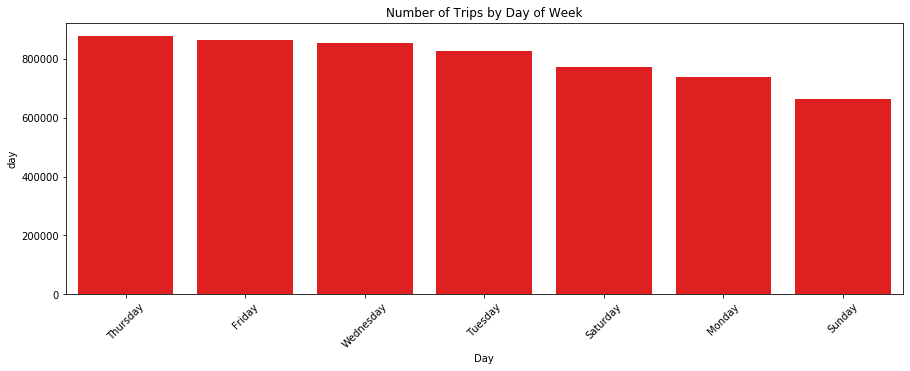

In [22]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x = days_df['Day'], y = days_df['day'], color = "red").set_title("Number of Trips by Day of Week")

In [23]:
holidays_df = pd.DataFrame(df.holiday.value_counts()).rename_axis('Holiday').reset_index()
holidays_df

,Holiday,holiday
0,Presidents Day,15299
1,Veterans Day,12107
2,Columbus Day,11409
3,Memorial Day,10283
4,Labor Day,9189
5,Thanksgiving,8297
6,July 4th,8030
7,Martin Luther King Jr. Day,7738
8,Christmas,5393
9,New Years Day,15


Text(0.5, 1.0, 'Number of Trips by Holiday')

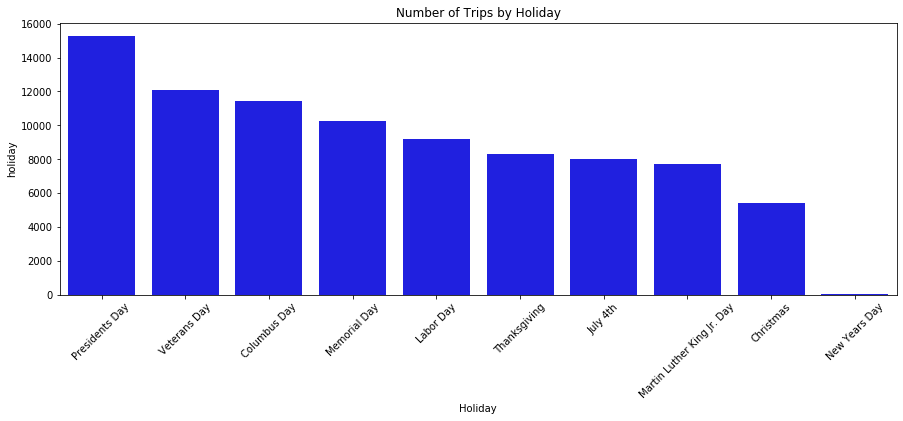

In [24]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x = holidays_df['Holiday'], y = holidays_df['holiday'], color = "blue").set_title("Number of Trips by Holiday")

In [25]:
hours_df = pd.DataFrame(df.hour.value_counts()).rename_axis('Hour').reset_index()
hours_df

,Hour,hour
0,18,390895
1,19,360143
2,17,356478
3,20,317887
4,16,314814
5,15,309405
6,21,304966
7,14,294128
8,9,292177
9,8,287773


Text(0.5, 1.0, 'Number of Trips by Hour of Day')

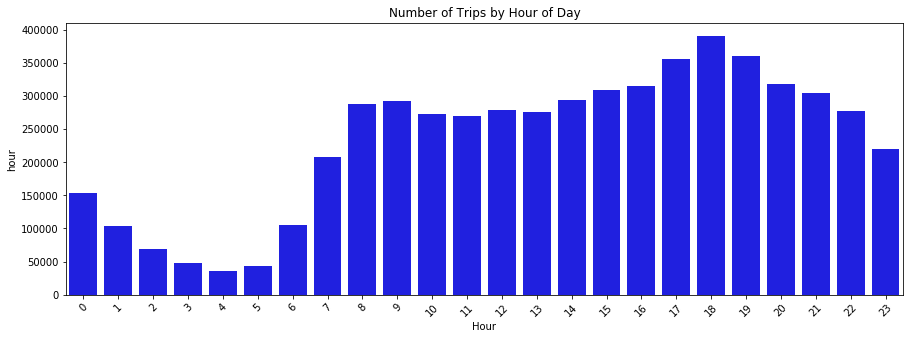

In [26]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x = hours_df['Hour'], y = hours_df['hour'], color = "blue").set_title("Number of Trips by Hour of Day")

Text(0.5, 1.0, 'Number of Trips by hour of day - Saturday')

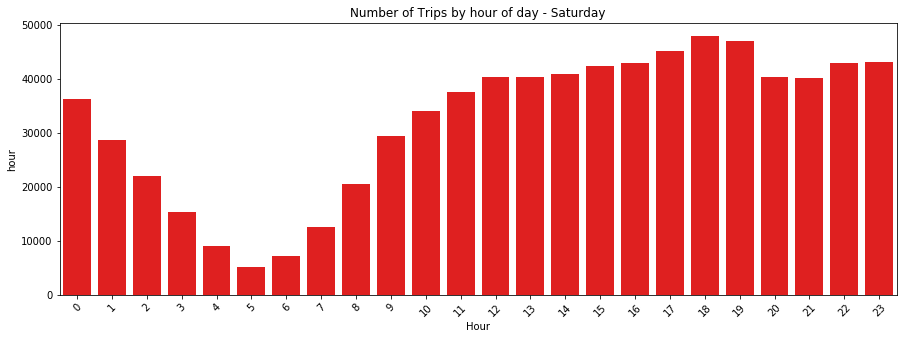

In [27]:
hours_sat = pd.DataFrame(df[df['day']=="Saturday"].hour.value_counts()).rename_axis('Hour').reset_index()
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)

sns.barplot(x = hours_sat['Hour'], y = hours_sat['hour'], color = "red").set_title("Number of Trips by hour of day - Saturday")


### Total Fare Amount

Text(0.5, 1.0, 'Total Fare Amount')

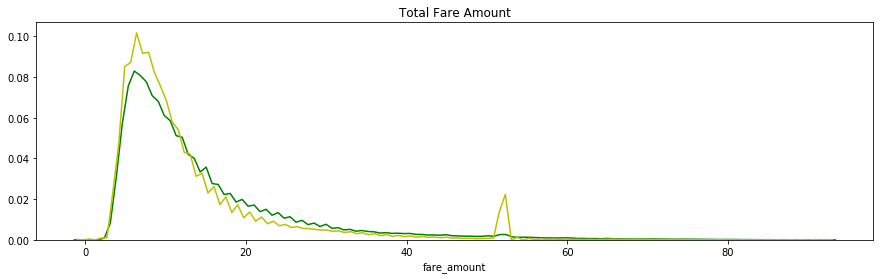

In [28]:
plt.figure(figsize=(15,4))
sns.distplot(df[df['cab']=='green']['fare_amount'], hist=False, color = "green")
sns.distplot(df[df['cab']=='yellow']['fare_amount'], hist=False, color = "y").set_title('Total Fare Amount')

In [29]:
df.groupby('cab')['fare_amount'].mean()

cab
green     14.706683
yellow    13.231269
Name: fare_amount, dtype: float64

On average, the total fare amount for green cabs is slightly greater than yellow cabs. We can check if this is due to longer trip times & higher distances traveled in green cabs than yellow cabs, shown below:

### Total Trip Time

Text(0.5, 1.0, 'Total Trip Time')

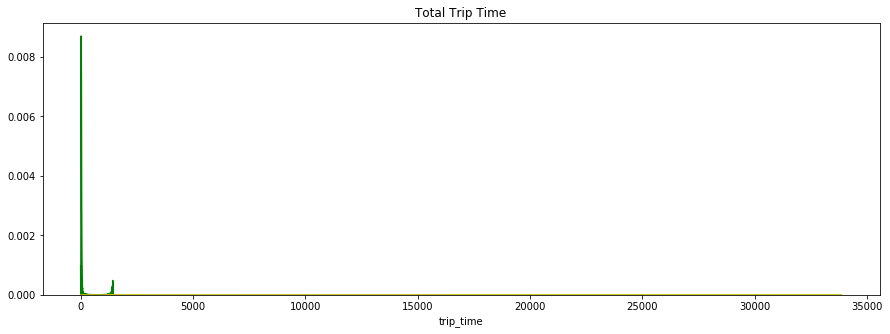

In [30]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=='green']['trip_time'], hist = False, color = "green")
sns.distplot(df[df['cab']=='yellow']['trip_time'], hist = False, color = "y").set_title('Total Trip Time')

In [31]:
df.groupby('cab')['trip_time'].mean()

cab
green     21.740038
yellow    17.710275
Name: trip_time, dtype: float64

Text(0.5, 1.0, 'Total Trip Distance')

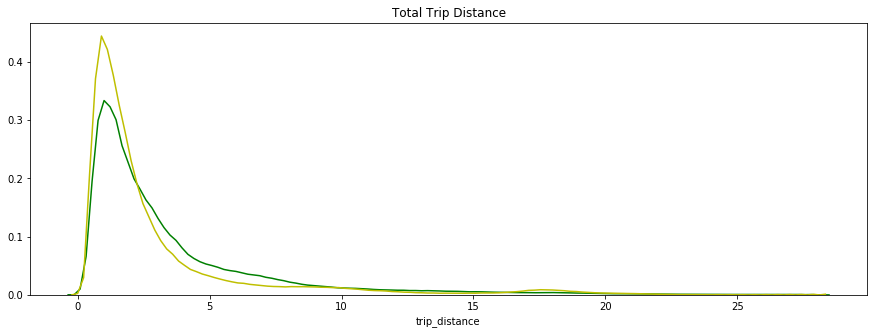

In [32]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=='green']['trip_distance'], hist = False, color = "green")
sns.distplot(df[df['cab']=='yellow']['trip_distance'], hist = False, color = "y").set_title('Total Trip Distance')

In [33]:
df.groupby('cab')['trip_distance'].mean()

cab
green     3.580373
yellow    3.047568
Name: trip_distance, dtype: float64

On average, the trip times and distances are slightly higher for green cabs which is consistent with the higher fare amounts.

### Total Tip Amount

Text(0.5, 1.0, 'Total Tip Amount')

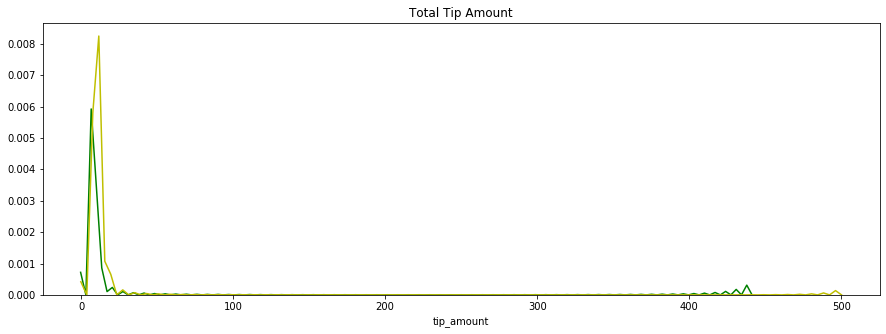

In [34]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=='green']['tip_amount'], hist = False, color = "green")
sns.distplot(df[df['cab']=='yellow']['tip_amount'], hist = False, color = "y").set_title('Total Tip Amount')

In [35]:
df.groupby('cab')['tip_amount'].mean()

cab
green     1.924916
yellow    3.042315
Name: tip_amount, dtype: float64

In [36]:
# Total transactions by cab type:
df[df['tip_amount']>=0].groupby('cab')['tip_amount'].count()

cab
green     2297989
yellow    3294921
Name: tip_amount, dtype: int64

In [37]:
# Total 0-tip transactions by cab type:
df[df['tip_amount']==0].groupby('cab')['tip_amount'].count()

cab
green     703713
yellow    120436
Name: tip_amount, dtype: int64

* For green cabs, approximately 31% of all transactions don't have tips.
* For yellow cabs, approximately 4% of all transactions dont have tips.

### Trip Speed vs. Tip Amount

In [38]:
# Pearson correlation coefficient of trip speed and tip amount:
df[['avg_speed','tip_amount']].corr()

,avg_speed,tip_amount
avg_speed,1.000000,0.248227
tip_amount,0.248227,1.000000


There is a weak correlation between trip speed and the tip amount.

## Modeling

Models to consider:
* Zero Inflated
* Random Forest
* XGBoost
* Neural Net
* GAM
* KNN
* Logistic Regression (to predict action of tipping)

In [ ]:
df_test = df

In [39]:
df_test['hour'] = df_test['hour'].astype(str)

In [40]:
df_test['hour_test'] = 'hour'
df_test['hour'] = df_test['hour_test'] + df_test['hour']

In [41]:
# one-hot encode categorical variables

# create dummys without na class
df_test = pd.get_dummies(df_test, dummy_na= False,  \
                    columns= ['passenger_count','cab', 'day','hour','month','improvement_surcharge',
                              'congestion_surcharge', 'mta_tax', 'extra'])

# create dummies with na class
df_test = pd.get_dummies(df_test, dummy_na= True, columns= ['holiday','Zone','Borough'])

# clean up column names
df_test.columns = df_test.columns.str.replace(' ', '_')
df_test.columns = df_test.columns.str.replace('.0$', '')
df_test.columns = df_test.columns.str.replace('/', '_')
df_test.columns = df_test.columns.str.replace('.', '_')

In [44]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_test.isna().sum()

tip_amount                                                 0
tip_ind                                                    0
trip_distance                                              0
fare_amount                                                0
tolls_amount                                               0
trip_time                                                  0
avg_speed                                                  0
holiday_NYE                                                0
Precipitation                                              1
Snow_depth                                                 1
Snowfall                                               15339
Max_temp                                                   1
Min_temp                                                   1
Avg_wind_speed                                        955771
Gust_speed                                            955771
hour_test                                                  0
passenger_count_1       

### Split into train validation and test sets

In [45]:
# pull 10% of data to store as test
test_df = df.sample(frac=0.1, random_state=44)

# remove test set from data
df = df.drop(test_df.index)

# create train set with 70% of remaining cases
train_df = df.sample(frac=.7, random_state=44)

# create validation set
validation_df = df.drop(train_df.index)

### Scale Continous Values

In [46]:
# obtain scales from train set

from sklearn import preprocessing

continous = train_df[['trip_distance', 'fare_amount','tolls_amount', 
                      'trip_time','avg_speed','Precipitation', 
                      'Snow_depth', 'Snowfall','Max_temp',
                      'Min_temp','Avg_wind_speed','Gust_speed']]

scaler = preprocessing.MinMaxScaler().fit(continous)
continous = scaler.transform(continous)


train_df[['trip_distance', 'fare_amount','tolls_amount', 
                      'trip_time','avg_speed','Precipitation', 
                      'Snow_depth', 'Snowfall','Max_temp',
                      'Min_temp','Avg_wind_speed','Gust_speed']] = continous

In [47]:
# apply scale to validation and test set

# validation
from sklearn import preprocessing

apply_scale = validation_df[['trip_distance', 'fare_amount','tolls_amount', 
                      'trip_time','avg_speed','Precipitation', 
                      'Snow_depth', 'Snowfall','Max_temp',
                      'Min_temp','Avg_wind_speed','Gust_speed']]

apply_scale = scaler.transform(apply_scale)


validation_df[['trip_distance', 'fare_amount','tolls_amount', 
                      'trip_time','avg_speed','Precipitation', 
                      'Snow_depth', 'Snowfall','Max_temp',
                      'Min_temp','Avg_wind_speed','Gust_speed']] = apply_scale

# test 
apply_scale = test_df[['trip_distance', 'fare_amount','tolls_amount', 
                      'trip_time','avg_speed','Precipitation', 
                      'Snow_depth', 'Snowfall','Max_temp',
                      'Min_temp','Avg_wind_speed','Gust_speed']]

apply_scale = scaler.transform(apply_scale)


test_df[['trip_distance', 'fare_amount','tolls_amount', 
                      'trip_time','avg_speed','Precipitation', 
                      'Snow_depth', 'Snowfall','Max_temp',
                      'Min_temp','Avg_wind_speed','Gust_speed']] = apply_scale


In [48]:
validation_df

,tip_amount,tip_ind,trip_distance,fare_amount,tolls_amount,trip_time,avg_speed,holiday_NYE,Precipitation,Snow_depth,Snowfall,Max_temp,Min_temp,Avg_wind_speed,Gust_speed,hour_test,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,cab_green,cab_yellow,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_hou,hour_hour1,hour_hour,hour_hour11,hour_hour12,hour_hour13,hour_hour14,hour_hour15,hour_hour16,hour_hour17,hour_hour18,hour_hour19,hour_hour2,hour_hour,hour_hour21,hour_hour22,hour_hour23,hour_hour3,hour_hour4,hour_hour5,hour_hour6,hour_hour7,hour_hour8,hour_hour9,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,improvement_surcharge_0,improvement_surcharge_0_03,improvement_surcharge_0_3,congestion_surcharge_0,congestion_surcharge_0_75,congestion_surcharge_1,congestion_surcharge_2_5,congestion_surcharge_2_75,mta_tax_0,mta_tax_0_05,mta_tax_0_35,mta_tax_0_5,mta_tax_0_87,mta_tax_1_44,mta_tax_2_24,mta_tax_3_3,mta_tax_3_55,extra_0,extra_0_06,extra_0_3,extra_0_5,extra_0_8,extra_1,extra_1_3,extra_1_8,extra_2,extra_2_25,extra_2_45,extra_2_5,extra_2_75,extra_2_8,extra_2_95,extra_3,extra_3_25,extra_3_3,extra_3_5,extra_3_73,extra_3_75,extra_3_8,extra_4,extra_4_5,extra_4_96,extra_5,extra_5_5,extra_5_9,extra_7,extra_7_25,extra_7_5,extra_9_5,extra_11_58,extra_17_5,extra_18,extra_18_5,holiday_Christmas,holiday_Columbus_Day,holiday_July_4th,holiday_Labor_Day,holiday_Martin_Luther_King_Jr__Day,holiday_Memorial_Day,holiday_New_Years_Day,holiday_Presidents_Day,holiday_Thanksgiving,holiday_Veterans_Day,holiday_nan,Zone_Allerton_Pelham_Gardens,Zone_Alphabet_City,Zone_Arden_Heights,Zone_Arrochar_Fort_Wadsworth,Zone_Astoria,Zone_Astoria_Park,Zone_Auburndale,Zone_Baisley_Park,Zone_Bath_Beach,Zone_Battery_Park,Zone_Battery_Park_City,Zone_Bay_Ridge,Zone_Bay_Terrace_Fort_Totten,Zone_Bayside,Zone_Bedford,Zone_Bedford_Park,Zone_Bellerose,Zone_Belmont,Zone_Bensonhurst_East,Zone_Bensonhurst_West,Zone_Bloomfield_Emerson_Hill,Zone_Bloomingdale,Zone_Boerum_Hill,Zone_Borough_Park,Zone_Breezy_Point_Fort_Tilden_Riis_Beach,Zone_Briarwood_Jamaica_Hills,Zone_Brighton_Beach,Zone_Broad_Channel,Zone_Bronx_Park,Zone_Bronxdale,Zone_Brooklyn_Heights,Zone_Brooklyn_Navy_Yard,Zone_Brownsville,Zone_Bushwick_North,Zone_Bushwick_South,Zone_Cambria_Heights,Zone_Canarsie,Zone_Carroll_Gardens,Zone_Central_Harlem,Zone_Central_Harlem_North,Zone_Central_Park,Zone_Charleston_Tottenville,Zone_Chinatown,Zone_City_Island,Zone_Claremont_Bathgate,Zone_Clinton_East,Zone_Clinton_Hill,Zone_Clinton_West,Zone_Co-Op_City,Zone_Cobble_Hill,Zone_College_Point,Zone_Columbia_Street,Zone_Coney_Island,Zone_Corona,Zone_Country_Club,Zone_Crotona_Park,Zone_Crotona_Park_East,Zone_Crown_Heights_North,Zone_Crown_Heights_South,Zone_Cypress_Hills,Zone_DUMBO_Vinegar_Hill,Zone_Douglaston,Zone_Downtown_Brooklyn_MetroTech,Zone_Dyker_Heights,Zone_East_Chelsea,Zone_East_Concourse_Concourse_Village,Zone_East_Elmhurst,Zone_East_Flatbush_Farragut,Zone_East_Flatbush_Remsen_Village,Zone_East_Flushing,Zone_East_Harlem_North,Zone_East_Harlem_South,Zone_East_New_York,Zone_East_New_York_Pennsylvania_Avenue,Zone_East_Tremont,Zone_East_Village,Zone_East_Williamsburg,Zone_Eastchester,Zone_Elmhurst,Zone_Elmhurst_Maspeth,Zone_Eltingville_Annadale_Prince's_Bay,Zone_Erasmus,Zone_Far_Rockaway,Zone_Financial_District_North,Zone_Financial_District_South,Zone_Flatbush_Ditmas_Park,Zone_Flatiron,Zone_Flatlands,Zone_Flushing,Zone_Flushing_Meadows-Corona_Park,Zone_Fordham_South,Zone_Forest_Hills,Zone_Forest_Park_Highland_Park,Zone_Fort_Greene,Zone_Fresh_Meadows,Zone_Freshkills_Park,Zone_Garment_District,Zone_Glen_Oaks,Zone_Glendale,Zone_Governor's_Island_Ellis_Island_Liberty_Island,Zone_Gowanus,Zone_Gramercy,Zone_Gravesend,Zone_Great_Kills,Zone_Green-Wood_Cemetery,Zone_Greenpoint,Zone_Gr

### Write dfs to Data Directory 

In [ ]:
#test_df.to_csv('Data/test.csv')
#validation_df.to_csv('Data/validation.csv')
#train_df.to_csv('Data/train.csv')

## Logistic Regression - Tip classification

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
display(train_df.isna().sum())

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# IMPUTE MISSING VALUES FOR WEATHER DATA
train_df = train_df.dropna()

X = train_df.iloc[:,2:395]
y = train_df.loc[:,'tip_ind'] # Set target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) # Create train/test split

logitmod = LogisticRegression(random_state = 0).fit(X_train,y_train) # Fit model

log_preds = logitmod.predict(X_test) # predict

In [ ]:
X.head()

In [ ]:
logitmod.score(X_test,y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test, log_preds)
print(confusion_matrix)
print(classification_report(y_test, log_preds))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, log_preds)
fpr, tpr, thresholds = roc_curve(y_test, logitmod.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Lasso

In [ ]:
lassomod = LogisticRegression(C = 0.10, penalty = "l1", solver = "liblinear")
lassofit = lassomod.fit(X_train, y_train)
preds_lasso = lassofit.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test, preds_lasso)
print(confusion_matrix)
print(classification_report(y_test, preds_lasso))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, preds_lasso)
fpr, tpr, thresholds = roc_curve(y_test, logitmod.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## XGB / Random Forest

In [49]:
train_df.shape

(3523533, 403)

In [50]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# IMPUTE MISSING VALUES FOR WEATHER DATA
train_df = train_df.dropna()

X = train_df.iloc[:,2:403]
y = train_df.loc[:,'tip_ind'] # Set target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) # Create train/test split

# Instantiate the XGBRegressor
xg_clf = xgb.XGBRFClassifier(objective='auc', n_estimators=100, seed=44, max_depth=10)

# Fit the regressor to the training set
xg_clf.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test, preds_lasso)
print(confusion_matrix)
print(classification_report(y_test, preds_lasso))

## Generalized Additive Model (GAM)

In [ ]:
# Features to include in model:
features = ['trip_distance', 'fare_amount',
        'trip_time', 'avg_speed']

In [ ]:
# Set features (X) and target (y) matrices in the training set:
X = train_df[features]
y = train_df.loc[:,'tip_amount']

# Train-test split to fit the model on 80% of the training data, and test on the remaining 20% of the training data:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
y_train

In [ ]:
# Fit GAM:
from pygam import LinearGAM, s, f, GAM
pd.set_option('display.max_columns', None)
X_train.head()

In [ ]:
gam = LinearGAM(n_splines=4).gridsearch(X_train.values, y_train.values)

In [ ]:
y_preds = gam.predict(X_test)
plt.plot(y_test, y_preds,"*")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")

In [ ]:
from sklearn.metrics import mean_squared_error 
from math import sqrt

sqrt(mean_squared_error(y_test,y_preds))

## K-Nearest Neighbors (KNN)

In [ ]:
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=5)

X = train_df.iloc[:,np.r_[0,2:8]]
y = train_df.loc[:,'tip_ind'] # Set target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) # Create train/test split

knn_reg.fit(X_train, y_train)

### Predictions on test set

In [ ]:
y_preds = knn_reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error 
from math import sqrt

sqrt(mean_squared_error(y_test,y_preds))

In [ ]:
plt.scatter(y_test, y_preds)

In [ ]:
errors = y_preds - y_test
sns.distplot(errors, hist = True)

In [ ]:
p1 = sns.kdeplot(y_test, shade=True, color="r")
p1 = sns.kdeplot(y_preds, shade=True, color="b")
plt.show()

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Instantiate linear regression object
linear_reg = LinearRegression()

# Train with the objt
linear_reg.fit(X_train, y_train)

# Make prediction
lin_preds = linear_reg.predict(X_test)
sqrt(mean_squared_error(y_test,lin_preds))

In [ ]:
plt.plot(y_test, lin_preds,"*")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")